In [607]:
import import_asl
import importlib
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features
from sklearn.metrics import precision_recall_fscore_support
from tsfresh.feature_extraction import MinimalFeatureExtractionSettings, ReasonableFeatureExtractionSettings
from tsfresh.feature_extraction import FeatureExtractionSettings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats import mode
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder

In [38]:
importlib.reload(import_asl)

<module 'import_asl' from 'C:\\Users\\anura\\Documents\\Machine-Learning-Course-Project\\import_asl.py'>

In [45]:
def grid_search_length(length):   
    signs_all_ts = import_asl.import_data(length)
    signs_flat = import_asl.create_flat_df(signs_all_ts, spatial_scale=True)

    X = signs_flat.drop(['label', 'ID', 'folder'], axis=1)

    Y = signs_flat['label']
    le = LabelEncoder()
    le.fit(Y)
    y = le.transform(Y)

    clf = LogisticRegression(C=1, penalty='l1')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(cross_val_score(clf, X_train, y_train, verbose=1).mean())

In [ ]:
for length in [10, 20, 30, 40, 57]:
    grid_search_length(length)

## Baseline Model

In [51]:
signs_all_ts = import_asl.import_data(57)
signs_flat_57 = import_asl.create_flat_df(signs_all_ts, spatial_scale=False)
X = signs_flat_57.drop(['label', 'ID', 'folder'], axis=1)

Y = signs_flat_57['label']
le = LabelEncoder()
le.fit(Y)
y = le.transform(Y)

clf = svm.SVC(kernel='linear', C=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(cross_val_score(clf, X_train, y_train, verbose=1).mean())
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s finished


0.90752624199


### Test Accuracy

In [57]:
sum(clf.predict(X_test) == y_test)/len(y_test)

0.93146417445482865

In [56]:
precision_recall_fscore_support(y_test, clf.predict(X_test), average='macro')

(0.93884148015726954, 0.93718348902559445, 0.93155490328294632, None)

## SVM with spatial scaling and downsampling

In [278]:
signs_all_ts = import_asl.import_data(10)
signs_flat = import_asl.create_flat_df(signs_all_ts, spatial_scale=True)
X = signs_flat.drop(['label', 'ID', 'folder'], axis=1)

Y = signs_flat['label']
le = LabelEncoder()
le.fit(Y)
y = le.transform(Y)

clf = svm.SVC(kernel='linear', C=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(cross_val_score(clf, X_train, y_train, verbose=1).mean())

tctodd1
tctodd2
tctodd3
tctodd4
tctodd5
tctodd6
tctodd7
tctodd8
tctodd9


C:\Users\anura\Documents\Machine-Learning-Course-Project\import_asl.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['frame'] = df.index + 1
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


0.952723215676


## Right Hand Meta Features

In [417]:
df = signs_all_ts.copy()
df2 = signs_flat.copy()
df.ID = df.ID.astype(str)
df['ID'] = df['folder'] + df['label'] + df['ID']

g = df.groupby('ID')
df['ix'] = df.index.values

df['frame'] = g['ix'].rank(method='first')

df['frame'] = df['frame'].astype(int)

#y = df[['ID','label']].drop_duplicates()['label']
y = df[['ID','label']].drop_duplicates().set_index('ID')
df.drop(['label', 'folder', 'ix'], axis = 1, inplace=True)

df_R = df.ix[:,11:]


In [97]:
settings = FeatureExtractionSettings()

extracted_features = extract_features(df_R, 
                                      column_id="ID", 
                                      column_sort="frame",
                                     feature_extraction_settings=ReasonableFeatureExtractionSettings())

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 11/11 [11:22<00:00, 62.01s/it]


In [98]:
for col in extracted_features.columns:
    if (sum(pd.isnull(extracted_features[col])) > 0) or (sum(extracted_features[col]) == 0):
        del (extracted_features[col])

In [544]:
#extracted_features.columns
candidates = ['mean_autocorrelation', 'absolute_sum_of_changes', 'large_number_of_peaks', 'skewness', 
              'thumb_R_symmetry_looking','fore_R_symmetry_looking','little_R_symmetry_looking', 
              'mean_second_derivate_central', 'last_location_of_maximum',
              'first_location_of_maximum',  'sample_entropy'
             ]
filtered_features = list(extract_features(df_R, 
                                      column_id="ID", 
                                      column_sort="frame",
                                     feature_extraction_settings=MinimalFeatureExtractionSettings()).columns.values)
for col in extracted_features.columns:
    for candidate in candidates:
        if col.find(candidate) > -1:
            filtered_features.append(col)


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.07it/s]


In [545]:
for col in filtered_features:
    if col.find('R__length') > -1:
        filtered_features.remove(col)

In [546]:
y = y.sort_index()
X = np.array(extracted_features[filtered_features].sort_index())
X_train, X_test, y_train, y_test = train_test_split(X, y['label'], test_size=0.25, random_state=42)
clf = RandomForestClassifier(n_estimators=50,  
                             criterion='entropy',
                            max_depth=30)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
param_grid = {#"max_depth": [10, 30, None],
              #"max_features": [50, 70, 'auto'],
              #"min_samples_split": [2, 5],
              #"min_samples_leaf": [1, 3],
              "n_estimators": [50, 60, 100],
              "bootstrap": [True, False],
              #"criterion": ["gini", "entropy"]}
            }

grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=3)
grid_search.fit(X_train, y_train)

In [262]:
grid_search.best_params_

{'bootstrap': False, 'n_estimators': 100}

In [547]:
cross_val_score(clf, X_train, y_train, cv=5, verbose=3).mean()

[CV]  ................................................................
[CV] ................................. , score=0.940618, total=   3.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  ................................................................
[CV] ................................. , score=0.972772, total=   3.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV]  ................................................................
[CV] ................................. , score=0.922078, total=   3.5s
[CV]  ................................................................
[CV] ................................. , score=0.964481, total=   3.8s
[CV]  ................................................................
[CV] ................................. , score=0.951009, total=   3.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.4s finished


0.95019145927057502

In [549]:
extracted_features[filtered_features].columns[clf.feature_importances_ < 0.001]

Index(['little_R__minimum', 'little_R__median', 'y_R__minimum', 'y_R__median',
       'middle_R__median', 'middle_R__minimum', 'x_R__median',
       'z_R__sum_values', 'z_R__mean', 'z_R__median', 'thumb_R__median',
       'ring_R__last_location_of_maximum', 'ring_R__first_location_of_maximum',
       'little_R__first_location_of_maximum',
       'middle_R__last_location_of_maximum',
       'thumb_R__last_location_of_maximum',
       'thumb_R__first_location_of_maximum'],
      dtype='object')

In [548]:
sum(clf.predict(X_test) == y_test)/len(y_test)

0.96261682242990654

In [550]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         God       1.00      1.00      1.00         5
           I       0.86      1.00      0.92         6
      Norway       1.00      1.00      1.00         8
       alive       0.86      1.00      0.92         6
         all       1.00      1.00      1.00         6
      answer       0.80      0.80      0.80         5
         boy       1.00      1.00      1.00        10
    building       1.00      1.00      1.00         4
         buy       1.00      1.00      1.00         8
change_mind_       1.00      1.00      1.00         3
        cold       1.00      1.00      1.00         9
        come       1.00      1.00      1.00         7
computer_PC_       1.00      1.00      1.00         5
        cost       1.00      1.00      1.00         8
       crazy       0.80      1.00      0.89         4
      danger       0.90      1.00      0.95         9
        deaf       1.00      0.90      0.95        10
   different       1.00    

### Ensemble: Voting

In [418]:
df2['ID'] = df2['folder'] + df2['label'] + df2['ID'].astype(str)

In [551]:
X1 = df2.set_index('ID').drop(['folder', 'label'], axis=1)

In [552]:
X2 = extracted_features[filtered_features]
X = X1.merge(X2, right_index=True, left_index=True)

In [433]:
def eclf_fit(X, y):
    clf1 = LogisticRegression(C=1, penalty='l1')
    clf2 = svm.SVC(kernel='linear',C=1,probability=True)
    clf3 = RandomForestClassifier(n_estimators=100,  criterion='entropy', 
                                  max_depth=30, bootstrap=False)
    clf4 = KNeighborsClassifier(n_neighbors=1, p=1)
    
    X1 = X.ix[:,:220]
    X2 = X.ix[:,220:]
        
    clf1.fit(X1, y)
    clf2.fit(X1, y)
    clf3.fit(X2, y)
    clf4.fit(X, y)
    
    return clf1, clf2, clf3, clf4

In [511]:
def most_common(lst):
    return max(set(lst), key=lst.count)

def eclf_predict(X, clf1, clf2, clf3, clf4):
    X1 = X.ix[:,:220]
    X2 = X.ix[:,220:]
        
    y_pred1 = clf1.predict(X1)
    y_pred2 = clf2.predict(X1)
    y_pred3 = clf3.predict(X2)
    y_pred4 = clf4.predict(X)
    
    y_pred = []
    
    for i in range(len(X)):
        y_pred.append(most_common([y_pred1[i],  y_pred2[i], y_pred3[i]]))
        
    return y_pred
            

In [570]:
X = X.sort_index()
y = y.sort_index()
X_train, X_test, y_train, y_test = train_test_split(X, y['label'], test_size=0.25, random_state=42)
clf1, clf2, clf3, clf4 = eclf_fit(X_train, y_train)

In [571]:
sum(eclf_predict(X_test, clf1, clf2, clf3, clf4) == y_test)/len(y_test)

0.97352024922118385

In [557]:
eclf1 = VotingClassifier(estimators=[
         ('lr', clf1),('svm', clf2), ('rf', clf3)], voting='soft')

In [556]:
cross_val_score(eclf1, X_train, y_train, verbose=3, cv=5).mean()

[CV]  ................................................................
[CV] ................................. , score=0.978622, total=  26.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.9s remaining:    0.0s


[CV]  ................................................................
[CV] ................................. , score=0.980198, total=  27.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.5s remaining:    0.0s


[CV]  ................................................................
[CV] ................................. , score=0.976684, total=  27.9s
[CV]  ................................................................
[CV] ................................. , score=0.980716, total=  28.4s
[CV]  ................................................................
[CV] ................................. , score=0.974212, total=  30.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


0.97808651464885377

In [558]:
eclf1.fit(X_train, y_train)
sum(eclf1.predict(X_test) == y_test)/len(y_test)

0.97975077881619943

In [559]:
w=[]

for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            w.append([w1, w2, w3])
            


In [577]:
parameters = {'lr__C':[1, 10],
             'svm__C':[1, 10]}
grid_search = GridSearchCV(eclf1,param_grid=parameters, verbose=3, cv=5)

In [578]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] svm__C=1, lr__C=1 ...............................................
[CV] ................ svm__C=1, lr__C=1, score=0.988124, total=  32.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.3s remaining:    0.0s


[CV] svm__C=1, lr__C=1 ...............................................
[CV] ................ svm__C=1, lr__C=1, score=0.992574, total=  33.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] svm__C=1, lr__C=1 ...............................................
[CV] ................ svm__C=1, lr__C=1, score=0.979221, total=  33.5s
[CV] svm__C=1, lr__C=1 ...............................................
[CV] ................ svm__C=1, lr__C=1, score=0.991803, total=  37.3s
[CV] svm__C=1, lr__C=1 ...............................................
[CV] ................ svm__C=1, lr__C=1, score=0.979827, total=  36.3s
[CV] svm__C=10, lr__C=1 ..............................................
[CV] ............... svm__C=10, lr__C=1, score=0.985748, total=  32.4s
[CV] svm__C=10, lr__C=1 ..............................................
[CV] ............... svm__C=10, lr__C=1, score=0.987624, total=  33.6s
[CV] svm__C=10, lr__C=1 ..............................................
[CV] ............... svm__C=10, lr__C=1, score=0.979221, total=  34.0s
[CV] svm__C=10, lr__C=1 ..............................................
[CV] ............... svm__C=10, lr__C=1, score=0.989071, total=  34.1s
[CV] s

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svm', SVC(C=1,...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         n_jobs=1, voting='soft', weights=[1, 2, 2]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__C': [1, 10], 'lr__C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [580]:
grid_search.best_params_

{'lr__C': 1, 'svm__C': 1}

In [574]:
grid_search.cv_results_

{'mean_fit_time': array([  33.39307923,   33.42195635,   33.11793079,   34.11960716,
          32.98135223,   32.6761229 ,   34.13689165,   34.18002162,
          34.71770077,   34.67520304,   34.11145768,   34.38548846,
          32.61198063,   32.7704988 ,   32.74576445,   33.30042334,
          32.72883544,   33.46751924,   38.90830626,   36.28291545,
          34.4086854 ,   34.64829817,   36.46163325,   36.81225023,
          36.3536653 ,   36.42960372,  130.73989139]),
 'mean_score_time': array([ 0.46078529,  0.45079341,  0.47678638,  0.44896808,  0.45290198,
         0.46321931,  0.46850867,  0.45959263,  0.46456099,  0.46853971,
         0.47489028,  0.47871747,  0.43954988,  0.44856143,  0.43767018,
         0.45021787,  0.44586568,  0.44752707,  0.45690064,  0.45938206,
         0.46472197,  0.46475072,  0.51099854,  0.4957984 ,  0.5197072 ,
         0.47391052,  0.47048297]),
 'mean_test_score': array([ 0.97815913,  0.98231929,  0.98387936,  0.98075923,  0.98439938,
        

In [572]:
eclf1.set_params(**grid_search.best_params_)
eclf1.fit(X_train, y_train)
sum(eclf1.predict(X_test) == y_test)/len(y_test)

0.98130841121495327

In [573]:
print(classification_report(y_test, eclf1.predict(X_test)))

              precision    recall  f1-score   support

         God       1.00      1.00      1.00         5
           I       1.00      1.00      1.00         6
      Norway       1.00      1.00      1.00         8
       alive       1.00      1.00      1.00         6
         all       1.00      1.00      1.00         6
      answer       1.00      1.00      1.00         5
         boy       1.00      1.00      1.00        10
    building       1.00      1.00      1.00         4
         buy       1.00      1.00      1.00         8
change_mind_       1.00      1.00      1.00         3
        cold       1.00      1.00      1.00         9
        come       1.00      1.00      1.00         7
computer_PC_       1.00      1.00      1.00         5
        cost       1.00      1.00      1.00         8
       crazy       0.67      0.50      0.57         4
      danger       0.90      1.00      0.95         9
        deaf       1.00      1.00      1.00        10
   different       1.00    

In [321]:
print(confusion_matrix(y_test, eclf1.predict(X_test), labels = eclf1.classes_))

[[ 5  0  0 ...,  0  0  0]
 [ 0  6  0 ...,  0  0  0]
 [ 0  0  8 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  6  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0  8]]


In [324]:
import pandas_ml as pdml

In [518]:
y_pred = eclf1.predict(X_test)
pdml.ConfusionMatrix(list(y_test), y_pred)

Predicted     God  I  Norway  alive  all  answer  boy  building  buy  \
Actual                                                                 
God             7  0       0      0    0       0    0         0    0   
I               0  5       0      0    0       0    0         0    0   
Norway          0  0      11      0    0       0    0         0    0   
alive           0  0       0      6    0       0    0         0    0   
all             0  0       0      0    7       0    0         0    0   
answer          0  0       0      0    0       4    0         0    0   
boy             0  0       0      0    0       0    8         0    0   
building        0  0       0      0    0       0    0         9    0   
buy             0  0       0      0    0       0    0         0    6   
change_mind_    0  0       0      0    0       0    0         0    0   
cold            0  0       0      0    0       0    0         0    0   
come            0  0       0      0    0       0    0         0 

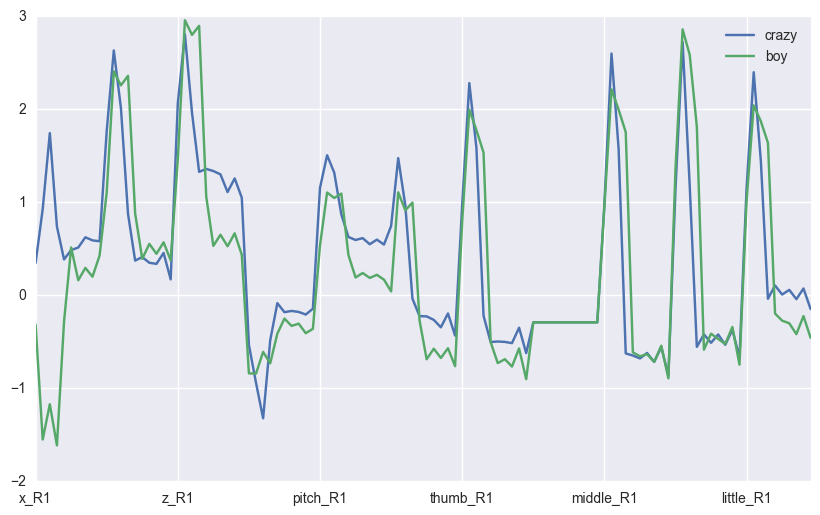

In [458]:
%matplotlib inline
ax = X.ix[:,110:220].ix['tctodd1crazy1.0'].plot(figsize=(10,6), legend='crazy', label='crazy')
X.ix[:,110:220].ix['tctodd1boy1.0'].plot(ax=ax, figsize=(10,6), label='boy', legend='boy')

In [485]:
X2.columns[np.argsort(clf3.feature_importances_)[:50]]

Index(['fore_R__number_cwt_peaks__n_5', 'little_R__number_cwt_peaks__n_5',
       'ring_R__number_cwt_peaks__n_5', 'middle_R__number_cwt_peaks__n_1',
       'middle_R__number_cwt_peaks__n_5', 'thumb_R__number_cwt_peaks__n_5',
       'yaw_R__number_cwt_peaks__n_1', 'y_R__number_cwt_peaks__n_5',
       'pitch_R__number_cwt_peaks__n_5', 'yaw_R__number_cwt_peaks__n_5',
       'pitch_R__number_cwt_peaks__n_1', 'thumb_R__number_cwt_peaks__n_1',
       'x_R__number_cwt_peaks__n_5', 'roll_R__number_cwt_peaks__n_5',
       'y_R__number_cwt_peaks__n_1', 'z_R__number_cwt_peaks__n_1',
       'thumb_R__first_location_of_maximum', 'z_R__number_cwt_peaks__n_5',
       'little_R__number_cwt_peaks__n_1', 'x_R__number_cwt_peaks__n_1',
       'z_R__median', 'y_R__minimum', 'roll_R__number_cwt_peaks__n_1',
       'x_R__median', 'little_R__median',
       'little_R__first_location_of_maximum',
       'ring_R__last_location_of_maximum', 'little_R__minimum',
       'middle_R__first_location_of_maximum', 'thu

In [472]:
np.where(clf1.classes_ == 'crazy')

(array([14], dtype=int64),)

In [476]:
clf1.feature_importances_

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [522]:
eclf2 = BaggingClassifier(eclf1)

In [523]:
eclf2.fit(X_train, y_train)

BaggingClassifier(base_estimator=VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svm', SVC(C=1,...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         n_jobs=1, voting='soft', weights=None),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [668]:
from keras.layers import LSTM
# define baseline model
def baseline_model(X, y):
    # create model
    # create model
    model = Sequential()
    model.add(LSTM(output_dim=300, input_dim=22
                   ,activation='tanh',inner_activation='hard_sigmoid', return_sequences=False ))
    #model.add(LSTM(output_dim =300 , activation='tanh',inner_activation='hard_sigmoid', return_sequences=False))
    model.add(Dense(95, activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [585]:
df.shape

(25650, 24)

In [588]:
n_features = 22
n_samples = 2565
n_steps = 10
nn_X = np.zeros((2565, n_features, n_steps))

In [598]:
for row in range(n_samples):
    for feature in range(n_features):
        nn_X[row, feature,:] = df.iloc[row*n_steps:(row+1)*n_steps,feature]

In [606]:
nn_X = np.swapaxes(nn_X, 1, 2)

In [611]:
nn_y = signs_all_ts['label']

In [615]:
nn_y = le.fit_transform(nn_y)

In [626]:
y_one_hot = np.zeros((n_samples, 95))
for i in range(n_samples):
    y_one_hot[i, nn_y[i*n_steps]] = 1

In [669]:
X_train, X_test, y_train, y_test = train_test_split(nn_X, y_one_hot, test_size=0.25, random_state = 42)
model = baseline_model(X_train, y_train)
model.fit(X_train, y_train,  batch_size=16, nb_epoch=15)

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\anura\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", input_shape=(None, 22), recurrent_activation="hard_sigmoid", return_sequences=False, units=300)`
C:\Users\anura\Anaconda3\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/15
1923/1923 [==============================] - 6s - loss: 0.0192 - acc: 0.0146     
Epoch 2/15
1923/1923 [==============================] - 5s - loss: 0.0103 - acc: 0.0640     
Epoch 3/15
1923/1923 [==============================] - 6s - loss: 0.0096 - acc: 0.1726     
Epoch 4/15
1923/1923 [==============================] - 5s - loss: 0.0079 - acc: 0.4046     
Epoch 5/15
1923/1923 [==============================] - 5s - loss: 0.0055 - acc: 0.6677     
Epoch 6/15
1923/1923 [==============================] - 5s - loss: 0.0034 - acc: 0.8388     
Epoch 7/15
1923/1923 [==============================] - 5s - loss: 0.0022 - acc: 0.9054     
Epoch 8/15
1923/1923 [==============================] - 5s - loss: 0.0014 - acc: 0.9392     
Epoch 9/15
1923/1923 [==============================] - 5s - loss: 0.0011 - acc: 0.9542     
Epoch 10/15
1923/1923 [==============================] - 5s - loss: 8.5806e-04 - acc: 0.9589     
Epoch 11/15
1923/1923 [==============================] - 6s - los

In [672]:
model.evaluate(nn_X, y_one_hot)

2496/2565 [============================>.] - ETA: 0s

[0.0002814265933598312, 0.98557504873294344]

In [673]:
batch_size = [10, 20, 40]
param_grid = {'nb_epoch':[15, 20, 25],
             'batch_size':batch_size}

In [ ]:
model = KerasClassifier(build_fn=baseline_model, epochs=15, batch_size=16)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=3)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
